In [1]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
#import pygraphviz as pygv
import os
from IPython.display import SVG, display


In [2]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(undirected='true', strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos, width=0.1, fontsize=9)
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    

def DrawSol (x):
    for i,j in G.edges():
        lab = x[i,j].x
        G[i][j]['capacity'] = x[i,j].x
        if x[i,j].x > 0.00001:
            if x[i,j].x > 0.999999:
                DrawG.add_edge(i, j, color='black', label=lab, fontsize=9)
            else:
                DrawG.add_edge(i, j, color='red', label=lab)
    path=str(basename)+'_sol.svg'
    DrawG.draw (path=path, format='svg')
    DrawG.delete_edges_from(DrawG.edges())
    
class args:
    filename = None
    scale = 40

## Multicommodity flow formulation


$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 


$$
y_{ij}= \{\text{capacity for the flow of each commodity $k$ in arc } (i,j)\}
$$

$$
f^k_{ij} = \{\text{flow of commodity $k$ carried by the arc } (i,j)\}
$$

\begin{alignat}{3}
\min cx &&\\
\sum_{j \in \delta^+(0)} f^k_{0j} - \sum_{j \in \delta^-(0)} f^k_{j0} = 1 &&\;\; \forall k \not = \{0\}\\
\sum_{j \in \delta^-(v)} f^k_{jv} - \sum_{j \in \delta^+(v)} f^k_{vj} = 0 &&\;\; \forall k \not = \{0\}, \forall v \in V, v \not = \{0\}, v \not = k \\
\sum_{j \in \delta^-(k)} f^k_{jk} - \sum_{j \in \delta^+(k)} f^k_{kj} = 1 && \;\; \forall k \not = \{0\} \\
f^k_{ij} \le y_{ij} && \;\; \forall (i,j) \text{ and } \forall k \not = \{0\}\\
\sum_{\{i,j\} \in E} (y_{ij} + y_{ji}) = n-1\\
y_{ij} + y_{ji} = x_e && \\
f \ge 0, \; x_e \in \{0,1\}\; 
\forall e \in E, \; \\y_{ij} \in \{0,1\} \; \forall (i,j) \in A
\end{alignat}

### Variables are declared BINARY but the polytope is integral

In [3]:
args.filename = "mst.gml"
args.scale = 40

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


In [5]:
D = G.to_directed()
root = 1
#DrawInitialGraph()
#display(SVG(filename=basename+'.svg'))



In [6]:
commodities = list(G.nodes())[1:]
nodessetminusroot = list(G.nodes())[1:]


mstmultiflow = gb.Model()


x = mstmultiflow.addVars(G.edges(), \
                         obj=[G[u][v]['cost'] for u,v in G.edges()],\
                        ub = 1.0,\
                        vtype=gb.GRB.BINARY,\
                        name='x')

y = mstmultiflow.addVars(D.edges(), ub=1.0, \
                         vtype=gb.GRB.BINARY, name='y')

f = mstmultiflow.addVars(D.edges(), commodities, \
                         ub=G.number_of_nodes(), \
                         vtype=gb.GRB.CONTINUOUS, name='f')



#
# Cardinality constraint
#

mstmultiflow.addConstr(y.sum() == \
                       G.number_of_nodes() - 1, "Cardinality")

mstmultiflow.update()


for u,v in G.edges():
 
    name = "Equality_x_(%d,%d)"%(u,v)
    mstmultiflow.addConstr(y[u,v] + y[v,u] -  x[u,v] == 0, name)
                          
                           
mstmultiflow.update()

#
# Variable capacity cons
#

for k in commodities:
    for u,v in D.edges():
        name = "Cap_(%d,%d)" % (u,v) + "_Com_" + str(k)
        mstmultiflow.addConstr (f [u,v,k] - y[u,v] <= 0, name)

mstmultiflow.update()


#
# Root constraints
#

for k in commodities:
    name = "Root_Com_"+str(k)
    mstmultiflow.addConstr(f.sum('*',root,k) - f.sum(root, '*', k) \
                           == 1, name)


#
# Balance constraints
#

for v in nodessetminusroot:
    for k in commodities:
        if (v != k):
            name = "Balance_"+str(v)+"_Com_"+str(k)
            mstmultiflow.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 0, name)
            

mstmultiflow.update()

#
# Terminal constraints
#

for k in commodities:
    name = "Term_Com_"+str(k)
    mstmultiflow.addConstr(f.sum(k,'*',k) - f.sum('*',k,k) == 1, name)

mstmultiflow.update()
mstmultiflow.write('mstmultiflow.lp')

In [17]:
mstmultiflow.optimize()

Optimize a model with 946 rows, 945 columns and 3465 nonzeros
Variable types: 810 continuous, 135 integer (135 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 23159.000000
Presolve removed 0 rows and 45 columns
Presolve time: 0.01s
Presolved: 946 rows, 900 columns, 3420 nonzeros
Variable types: 810 continuous, 90 integer (90 binary)

Root relaxation: objective 6.735000e+03, 384 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    6735.0000000 6735.00000  0.00%     -    0s

Explored 0 nodes (384 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 6735 23159 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.735000000000

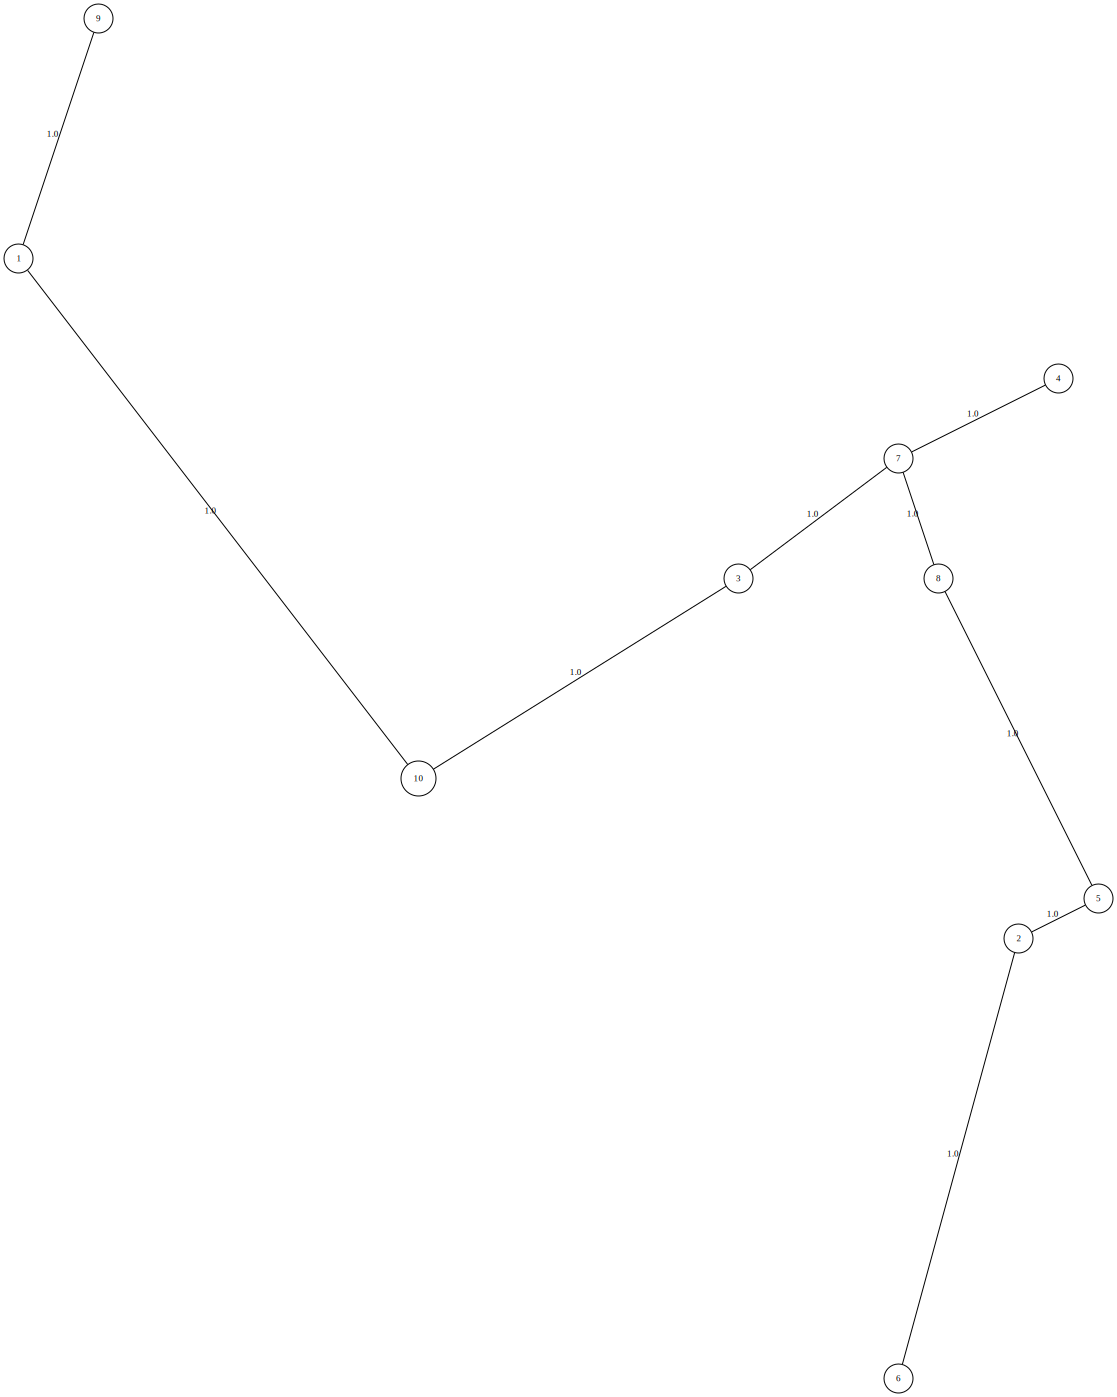

In [18]:
DrawSol(x)
display(SVG(filename=basename+'_sol.svg'))


